C:\Users\OrecchiaC\AppData\Local\Temp\ipykernel_9840\98766473.py:394: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(str(init_val['timestamp'])+'T').mean()


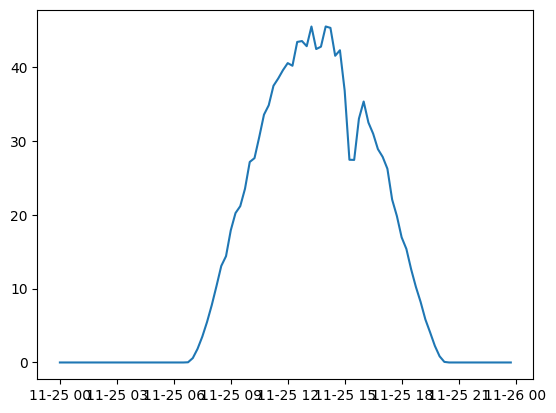

In [1]:
#Ottimizzatore di ricarica per 10 colonnine AC e 2 colonnine DC con comando via modbus di 3 EVSE reali (Delta DC, Alfen AC, Autel AC)
init_val={
    'timestamp':15,
    'numChargers' : 12,
    'v2g':False
}
# Lista con i SOC iniziali, capacità batteria, potenza massima, SOC finale
soc_values = [
    [0.4, 0.5],  # SOC iniziali per Station 0
    [0.4, 0.5],  # SOC iniziali per Station 1
    [0.4, 0.5],  # SOC iniziali per Station 2
    [0.4],   # SOC iniziali per Station 3
    [0.4],  # SOC iniziali per Station 4
    [0.4],  # SOC iniziali per Station 5
    [0.2],  # SOC iniziali per Station 6
    [0.2],  # SOC iniziali per Station 7
    [0.21],  # SOC iniziali per Alfen nissan 40kWh
    [0.41],  # SOC iniziali per Autel Nissan 62 kWh
    [0.4],  # SOC iniziali per Delta
    [0.5]  # SOC iniziali per Station 11
]
battery_capacity_values = [
    [13, 13],  # SOC iniziali per Station 0
    [42, 42],  # SOC iniziali per Station 1
    [75, 75],  # SOC iniziali per Station 2
    [42],   # SOC iniziali per Station 3
    [13],  # SOC iniziali per Station 4
    [26.8],  # SOC iniziali per Station 5
    [75],  # SOC iniziali per Station 6
    [26.8],  # SOC iniziali per Station 7
    [40],  # Capacità batteria per Alfen
    [62],  # Capacità batteria per Autel
    [75],  # Capacità batteria per Delta
    [75]  # SOC iniziali per Station 11
]
EV_nominal_power_values =[
    [3.6, 3.6],  # SOC iniziali per Station 0
    [11, 11],  # SOC iniziali per Station 1
    [11, 11],  # SOC iniziali per Station 2
    [11],   # SOC iniziali per Station 3
    [3.6],  # SOC iniziali per Station 4
    [7.4],  # SOC iniziali per Station 5
    [11],  # SOC iniziali per Station 6
    [7.4],  # SOC iniziali per Station 7
    [6.6],  # SOC iniziali per Alfen
    [6.6],  # SOC iniziali per Autel
    [40],  # SOC iniziali per Delta
    [250]  # SOC iniziali per Station 11
]
EV_nominal_power_values_v2g =[
    [3.6, 3.6],  # SOC iniziali per Station 0
    [11, 11],  # SOC iniziali per Station 1
    [11, 11],  # SOC iniziali per Station 2
    [11],   # SOC iniziali per Station 3
    [3.6],  # SOC iniziali per Station 4
    [7.4],  # SOC iniziali per Station 5
    [11],  # SOC iniziali per Station 6
    [7.4],  # SOC iniziali per Station 7
    [0],  # SOC iniziali per Alfen
    [0],  # SOC iniziali per Autel
    [0],  # SOC iniziali per Delta
    [250]  # SOC iniziali per Station 11
]

####################### DATI DI INPUT SULLE COLLONNINE DI RICARICA #############################
#Definire numero colonnine 
nWB=init_val['numChargers'] 
#set della potenza massima dei charging point
power_CP_values = [
    22, 22, 22, 22, 22, 22, 22, 22, 7.4, 7.4, 50, 50  #kW
]
#Potenza minima che le colonnine possono erogare
min_CP_values=[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 5, 5]  #kW

# dichiaro le efficienze dei caricabatterie
etaG2V=0.95
etaV2G=0.96

import pyomo.environ as pyo
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import random
import time as tm
import threading
import keyboard
import queue

from pymodbus.server import StartSerialServer
#from pymodbus.transaction import ModbusRtuFramer
from pymodbus.datastore import  (ModbusSequentialDataBlock, ModbusSlaveContext, ModbusServerContext)
from pymodbus.constants import Endian
from pymodbus.payload import BinaryPayloadBuilder
from pymodbus.payload import BinaryPayloadDecoder
from pymodbus.client import ModbusTcpClient
from pyModbusTCP.client import ModbusClient

from datetime import datetime
import struct
import math

#Definizione di tutti gli indirizzi IP usati nel setup sperimentale
IP_Mc = '192.168.170.170' #meter centrale
IP_M_Autel = '192.168.170.171' #meter Autel
IP_M_Alfen = '192.168.170.172' #meter Alfen
IP_M_Delta = '192.168.170.173' #meter Delta
IP_M_home_HH = '192.168.170.174' #meter load emulator HH
IP_M_PV = '192.168.170.175' #meter CINERGIA
IP_Alfen = '192.168.170.120' #EVSE Alfen
IP_Autel = '192.168.170.130' #EVSE Autel
IP_Delta = '192.168.170.150' #EVSE Delta
#IP_MOXA = '192.168.170.180'
#IP_PC = '192.168.170.253'

Mc = ModbusTcpClient(host = IP_Mc, port = 502) #meter centrale
#client1 = ModbusTcpClient(host = IP_M_Autel, port = 502) #meter Autel
M_Autel = ModbusTcpClient(host = IP_M_Autel, port = 502) #meter Autel
M_Alfen = ModbusTcpClient(host = IP_M_Alfen, port = 502) #meter Alfen
M_Delta = ModbusTcpClient(host = IP_M_Delta, port = 502) #meter Delta
M_home_HH = ModbusTcpClient(host = IP_M_home_HH, port = 502) #meter load emulator HH
M_PV = ModbusTcpClient(host = IP_M_PV, port = 502) #meter CINERGIA
Alfen = ModbusTcpClient(host = IP_Alfen, port = 502) #EVSE Alfen
Autel = ModbusTcpClient(host = IP_Autel, port = 502) #EVSE Autel
Delta = ModbusTcpClient(host = IP_Delta, port = 5020) #EVSE Delta


def stop():
    #stop ricarica per Delta
    while(True):
        #print("Premere ALT per stop Delta")
        if keyboard.is_pressed('alt'):  #se invece stoppare la ricarica
            lock.acquire()
            #Delta_WriteRegister(I_max_Delta_address,6) #scrittura su Delta 6A, in modo che al prossimo lancio di ricarica questo parte da 6A
            #Delta_WriteRegister(257,2) #scrittura su Delta
            Delta_WriteRegister(600,500) #scrittura su Delta. Impone 500W ->dovrebbe staccare la ricarica
            lock.release()
            #Delta_WriteRegister(Delta,I_max_Delta_address,6) #imponi 6A come limite max per prossima ripartenza
            print("Ricarica Delta stoppata")
            tm.sleep(5) #per lasciare il tempo di stoppare la ricarica

#METER
#definisco la funzione di lettura meter Siemens del registro 65 potenza attiva totale
# registro 25+26 (potenza attiva su L1)

def SiemensReadPower (siemens):
    if (siemens.connect()):
        reg = siemens.read_holding_registers(65, 2, slave=1) #legge il registro della potenza attiva della wallbox
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_32bit_float()
        siemens.close()
        f = round(f)

    return f 
    
#definisco la funzione di lettura meter Siemens dei registri qualsiasi addr e addr+1 
def SiemensRead (siemens, addr):
    if (siemens.connect()):
        reg = siemens.read_holding_registers(addr, 2, slave=1) #legge il registro della potenza attiva della wallbox
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_32bit_float()
        siemens.close()
        #return f 
    return f 

#funzione che restituisce la potenza assorbita dalla Delta ottenuta per differenza tra potenza totale(Mc) - potenza Autel - potenza Alfen
def SiemensDelta():
    f = SiemensReadPower(Mc) - SiemensReadPower(M_Alfen) - SiemensReadPower(M_Autel)
    return f


#ALFEN
Alfen_addr_P = 344  #registro potenza attiva Alfen. float32
Alfen_addr_V = 306  #registro tensione fase 1 Alfen. float32

#definisco la funzione di lettura registri su EVSE Alfen (Alfen AC). Registro 1210 (lettura/scrittura) max corrente 
def AlfenRead(addr):
    if (Alfen.connect()):
        reg = Alfen.read_holding_registers(addr, 2, slave=1) #legge il registro addr e addr+1
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_32bit_float()
        Alfen.close()
    else:
        for maxIter in range(10):
            tm.sleep(1)
            print('Tentativi connessione Alfen ',maxIter)
            if(Alfen.connect()):
                reg = Alfen.read_holding_registers(addr, 2, slave=1) #legge il registro addr e addr+1
                decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
                f = decoder.decode_32bit_float()
                Alfen.close()
    return f

#definisco la funzione di scrittura registri su EVSE Alfen (Alfen AC). Usata per scrivere la max corrente (floating point 32 bit)
#If you need to write floating point values, you'll have to build a payload and then write it to the registers   
#Registro 1210 (lettura/scrittura) max corrente 
def Alfen_WriteRegister(val):
    if (Alfen.connect()):
        builder = BinaryPayloadBuilder(wordorder=Endian.BIG, byteorder=Endian.BIG)    
        builder.add_32bit_float(val)
        payload = builder.to_registers()
        Alfen.write_registers(1210, payload, slave=1)
        Alfen.close()
    else:
        for iter in range(5):
            tm.sleep(1)
            print("Tentativi di connessione Alfen ",iter)
            if (Alfen.connect()):
                builder = BinaryPayloadBuilder(wordorder=Endian.BIG, byteorder=Endian.BIG)    
                builder.add_32bit_float(val)
                payload = builder.to_registers()
                Alfen.write_registers(1210, payload, slave=1)
                Alfen.close()

#Funzione che setta la potenza di ricarica (in kW) desiderata dell'Alfen. 2% margine
def AlfenSetPower(val):
    if (val == 0):
        Alfen_WriteRegister(0)
        tm.sleep(1)
        # if SiemensReadPower(M_Alfen) > 100:
        #     print("! l'Alfen sta assorbendo più di 100W -> ", round(SiemensReadPower(M_Alfen),1), "W")
    else:
        corrente = round(val*1000/230)
        Alfen_WriteRegister(corrente)
        #prima iterazione
        # tensione = AlfenRead(Alfen_addr_V)
        # corrente = round(0.98*val*1000/tensione, 2)
        # Alfen_WriteRegister(corrente)
        # tm.sleep(4)
        # #seconda iterazione
        # tensione = AlfenRead(Alfen_addr_V)
        # corrente = round(0.98*val*1000/tensione, 2)
        # Alfen_WriteRegister(corrente)
        # tm.sleep(3)

        # if SiemensReadPower(M_Alfen) > val*1000:  #se la potenza assorbita è ancora maggiore mette un margine del 5%
        #     tensione = AlfenRead(Alfen_addr_V)
        #     corrente = round(0.95*val*1000/tensione, 2)
        #     Alfen_WriteRegister(corrente)
        #     tm.sleep(3)
        #     if SiemensReadPower(M_Alfen) > val*1000:
        #         print("Errore, la potenza dell'Alfen è maggiore del setpoint scelto")
        
        # print("L'ALfen sta assorbendo ", round(SiemensReadPower(M_Alfen),1), "W")


#AUTEL
Autel_addr_P = 10021  #registro per la potenza della fase 1. uint32

def AutelReadPower():  #Funzione lettura input register uint32 slave=1
    if (Autel.connect()):
        reg=Autel.read_input_registers(10021, 2, slave=1)
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_32bit_uint()
        #Autel.close()
    return f

def AutelSetPower(val):
    if (Autel.connect()):
        val = val*1000
        val = int(val)
        builder = BinaryPayloadBuilder(wordorder=Endian.BIG, byteorder=Endian.BIG)    
        builder.add_32bit_uint(val)
        payload = builder.to_registers()
        Autel.write_registers(20000, payload, slave=1)
        #Autel.close()
    else:
        for iter in range(5):
            tm.sleep(1)
            print("Tentativi di connessione Autel ",iter)
            if (Autel.connect()):
                val = int(val*1000)
                builder = BinaryPayloadBuilder(wordorder=Endian.BIG, byteorder=Endian.BIG)    
                builder.add_32bit_uint(val)
                payload = builder.to_registers()
                Autel.write_registers(20000, payload, slave=1)
                print("Potenza Autel messa a ", val, "kW")
                #Autel.close()


def AutelReadSetpoint():
    if (Autel.connect()):
        reg = Autel.read_holding_registers(20000, 2, slave=1)
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_32bit_uint()
    else:
        for iter in range(5):
            tm.sleep(1)
            print("Tentativi di connessione Autel ",iter)
            if (Autel.connect()):
                reg = Autel.read_holding_registers(20000, 2, slave=1)
                decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
                f = decoder.decode_32bit_uint()      
    return f

#DELTA
#definisco la funzione di lettura registri su EVSE Delta (Delta DC 50kW). Per leggere la potenza assorbita registro 047 float32
#slave = 2  CCS Combo
#slave = 3  CHAdeMO
#Nel codice va definita la variabile DeltaSlave
def DeltaRead (addr):  #legge float32. Bisogna inserire lo slave (CHAdeMO o CCS Combo)
    #lock.acquire()
    if (Delta.connect()):
        reg=Delta.read_input_registers(addr, 2, slave=DeltaSlave)
        #reg = Delta.read_holding_registers(addr, 2, slave=1) #legge il registro addr
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_32bit_float()
        Delta.close()
    #lock.release()
    return f 

#funzione lettura del setpoint di potenza EVSE Delta. Registro 600 int32 write holding register
def DeltaReadSetpoint ():
    if (Delta.connect()):
        #reg=Delta.read_input_registers(47, 2, slave=2)
        reg = Delta.read_holding_registers(600, 2, slave=DeltaSlave) #legge il registro 600
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_32bit_int()
        Delta.close()
    else:
        for iter in range(5):
            tm.sleep(1)
            print("Tentativi di connessione Delta ",iter)
            if (Delta.connect()):
                reg = Delta.read_holding_registers(600, 2, slave=DeltaSlave) #legge il registro 600
                decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
                f = decoder.decode_32bit_int()
                Delta.close()
    return f

#definisco la funzione di scrittura registri su EVSE Delta (Delta DC). Per scrivere la max potenza. Registro 600 int32
DeltaSlave=3 #CHAdeMO
#DeltaSlave=2 #CCS Combo

def DeltaSetPower(val):
    if (Delta.connect()):
        val = val*1000
        val = int(val) #lo trasforma in int se inserisco un valore float
        builder = BinaryPayloadBuilder(wordorder=Endian.BIG, byteorder=Endian.BIG)    
        builder.add_32bit_int(val)
        payload = builder.to_registers()
        Delta.write_registers(600, payload, slave=DeltaSlave)
        Delta.close()
    else:
        for iter in range(5):
            tm.sleep(1)
            print("Tentativi di connessione Delta ",iter)   
            if (Delta.connect()):
                val = val*1000
                val = int(val) #lo trasforma in int se inserisco un valore float
                builder = BinaryPayloadBuilder(wordorder=Endian.BIG, byteorder=Endian.BIG)    
                builder.add_32bit_int(val)
                payload = builder.to_registers()
                Delta.write_registers(600, payload, slave=DeltaSlave)
                Delta.close()      

#restituisce un intero di 3 cifre
def DeltaReadSOC():
    if (Delta.connect()):
        reg=Delta.read_input_registers(11, 1, slave=DeltaSlave)
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_16bit_uint()
        Delta.close()
    else:
        for iter in range(5):
            tm.sleep(1)
            print("Tentativi di connessione Delta ",iter)
            if (Delta.connect()):
                reg=Delta.read_input_registers(11, 1, slave=DeltaSlave)
                decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
                f = decoder.decode_16bit_uint()
                Delta.close()
    return f


#OTTIMIZZATORE

def process_building_load(buildingLoadScaling):
    # Carica il file Excel
    file_path = r'Building_load.xlsx'
    df = pd.read_excel(file_path)

    # Rimuovi spazi bianchi dai valori della colonna "Time"
    df['Time'] = df['Time'].str.strip()

    # Converti la colonna "Time" in formato datetime
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

    # Imposta la colonna "Time" come indice
    df.set_index('Time', inplace=True)

    # Risample i dati ogni 5 minuti calcolando la media
    df_resampled = df.resample(str(init_val['timestamp'])+'T').mean()

    # Converti la colonna "Potenza normalizzata [W]" in un vettore np.array
    potenza_norm_array = df_resampled['Potenza normalizzata [W]'].to_numpy()

    # Calcola il vettore di potenza giornaliero scalando il profilo sul massimo dell'edificio
    potenza_build_array = potenza_norm_array * buildingLoadScaling * 0.7

    return potenza_build_array

def process_pv_production():
    # Leggi il file Excel
    file_path = r'pv_production.xlsx'
    df = pd.read_excel(file_path)

    # Assicurati che le colonne abbiano i nomi corretti
    df.columns = ['Time', 'Value']

    # Converte i dati in un np.array
    original_values = np.array(df['Value'])

    # I tuoi dati originali ogni 15 minuti
    original_time = np.arange(0, 24, 0.25)  # ad esempio da 0 a 24 ore

    # Nuovi intervalli di tempo ogni 5 minuti
    new_time = np.arange(0, 24, init_val['timestamp']/60.)  # da 0 a 24 ore, ogni 5 minuti

    # Usa numpy.interp per interpolare i nuovi valori
    new_values = np.interp(new_time, original_time, original_values)

    return new_values

def array_pun():
    # Carica il file Excel
    file_path=r'hourly_price_PUN.xlsx'
    df = pd.read_excel(file_path)
    
    # Supponiamo che la colonna dei prezzi orari si chiami '€/kWh'
    prezzi_orari = df['€/kWh'].values
    
    # Creiamo un array numpy che ripete ogni valore 12 volte (12 * 5 minuti = 1 ora)
    prezzi_5_minuti = np.repeat(prezzi_orari, 60/init_val['timestamp'])
    
    return prezzi_5_minuti

def time_to_index(hour, minute):
    """Converte un orario (ora, minuto) in un indice del vettore (5 minuti)"""
    return (hour * 60 + minute) // init_val['timestamp']

def create_schedule(connection_times, disconnection_times, num_stations=init_val['numChargers'], intervals_per_day=int((60/init_val['timestamp'])*24)):
    """
    Crea la schedule di connessione/disconnessione per le colonnine.
    
    Parameters:
    - connection_times: lista di liste di tuple (ora, minuto) per la connessione
    - disconnection_times: lista di liste di tuple (ora, minuto) per la disconnessione
    - num_stations: numero di colonnine
    - intervals_per_day: numero di intervalli di 5 minuti in un giorno (288)
    
    Returns:
    - schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione
    """
    schedules = np.zeros((num_stations, intervals_per_day), dtype=int)
    
    for i in range(num_stations):
        for conn, disc in zip(connection_times[i], disconnection_times[i]):
            conn_index = time_to_index(*conn)
            disc_index = time_to_index(*disc)
            if conn_index < disc_index:
                schedules[i, conn_index:disc_index] = 1
            else:  # gestione di connessione durante la notte (es. dalle 23:00 alle 02:00)
                schedules[i, conn_index:] = 1
                schedules[i, :disc_index] = 1
    
    return schedules

def calculate_residence_times(schedule):
    """
    Calcola il tempo di residenza per ogni veicolo e lo restituisce come una lista di liste.
    
    Parameters:
    - schedule: lista di liste che rappresenta la connessione dei veicoli a una stazione di ricarica (0 o 1)
    
    Returns:
    - residence_times: lista di liste con i tempi di residenza per ogni veicolo in ogni stazione (in minuti)
    """
    residence_times = []
  

    # Itera su ogni stazione di ricarica
    for station_schedule in schedule:
        station_residence_times = []
        block_time = 0

        # Itera su ogni intervallo di tempo nella stazione
        for val in station_schedule:
            if val == 1:
                block_time += init_val['timestamp'] 
            else:
                if block_time > 0:
                    # Aggiunge il tempo totale di residenza del veicolo
                    station_residence_times.append(block_time)
                    block_time = 0

        # Gestisci il caso in cui ci sia un blocco alla fine della lista
        if block_time > 0:
            station_residence_times.append(block_time)

        # Aggiungi i tempi di residenza per la stazione corrente
        residence_times.append(station_residence_times)

    return residence_times

def find_disconnection_times(extended_schedules):
    """
    Trova l'ultimo istante di connessione per ogni colonnina, che è seguito da una disconnessione,
    e restituisce un dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps
    di disconnessione.

    Parameters:
    - extended_schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione

    Returns:
    - disconnection_times: dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps di disconnessione
    """
    num_stations, intervals_per_day = extended_schedules.shape
    disconnection_times = {}

    for i in range(num_stations):
        station_schedule = extended_schedules[i]
        times = []

        # Trova tutti i punti di transizione da 1 a 0
        for t in range(1, intervals_per_day):
            if station_schedule[t-1] == 1 and station_schedule[t] == 0:
                # Aggiungi l'ultimo istante di connessione prima della disconnessione
                times.append(t-1)
            # elif station_schedule[t]==1 and t==(intervals_per_day-1):
            #     #Aggiungi l'ultimo istante di connessione se alla fine della schedule
            #     times.append(t)
        # Se non ci sono disconnessioni, inserisci "0" se non ci sono mai connessioni
        if not times:
            if np.all(station_schedule == 0):
                disconnection_times[i] = [0]
            else:
                disconnection_times[i] = []
        else:
            disconnection_times[i] = times

    return disconnection_times

def find_connection_times(extended_schedules):
    """
    Trova tutti gli istanti di tempo in cui per ogni colonnina si ha la connessione di un veicolo e
    restituisce un dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps
    di disconnessione.
    
    Parameters:
    - extended_schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione
    
    Returns:
    - connection_times: dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps di connessione
    """
    num_stations, intervals_per_day = extended_schedules.shape
    connection_times = {}
    
    for i in range(num_stations):
        station_schedule = extended_schedules[i]
        times = []
        
        # Trova tutti i punti di transizione da 0 a 1
        for t in range(1, intervals_per_day):
            if station_schedule[t-1] == 0 and station_schedule[t] == 1:
                times.append(t)
        
        # Se non ci sono disconnessioni, inserisci "0" se non ci sono mai connessioni
        if not times:
            if np.all(station_schedule == 0):
                connection_times[i] = [0]
            else:
                connection_times[i] = []
        else:
            connection_times[i] = times

    return connection_times

def calculate_final_soc(initial_soc, PchMax_vehicles, residence_times, battery_capacity, min_soc=0.7, F=0.7):
    """
    Calcola lo stato di carica finale per ogni veicolo e lo restituisce come una lista di liste.
    
    Parameters:
    - initial_soc: lista di liste con lo stato di carica iniziale per ogni veicolo in ogni stazione
    - PchMax_vehicles: lista di liste con la potenza massima con cui può avvenire la ricarica del veicolo, in ogni stazione (kW)
    - residence_times: lista di liste con il tempo di residenza per ogni veicolo in ogni stazione (in minuti)
    - battery_capacity: lista di liste con la capacità della batteria per ogni veicolo in ogni stazione (kWh)
    - min_soc: lo stato di carica minimo da garantire, se il tempo di residenza è sufficiente (default 0.7)
    - F: fattore di rilassamento per permettere all'ottimizzatore di modulare la carica (default 0.7)
    
    Returns:
    - final_soc: lista di liste con lo stato di carica finale per ogni veicolo in ogni stazione
    """
    final_soc = []

    # Itera attraverso le stazioni
    for i, station_vehicles in enumerate(initial_soc):
        station_final_soc = []

        # Controlla se la lista dei tempi di residenza è vuota per la stazione
        if not residence_times[i]:
            # Se non ci sono veicoli, assegna 0 come final_soc
            station_final_soc = [0 for _ in station_vehicles]
        else:
            # Itera attraverso i veicoli nella stazione
            for j, soc in enumerate(station_vehicles):
                current_soc = soc

                # Estrai il tempo di residenza, potenza di ricarica e capacità della batteria
                total_residence_time = residence_times[i][j] / 60  # Converti in ore
                charge_increment = (PchMax_vehicles[i][j] * total_residence_time) / battery_capacity[i][j]

                # Calcola lo stato di carica finale
                final_soc_value = min(min_soc, (current_soc + F* charge_increment))

                # Aggiungi il risultato alla lista della stazione
                station_final_soc.append(final_soc_value)

        # Aggiungi i risultati della stazione all'output finale
        final_soc.append(station_final_soc)

    return final_soc

def plot_schedule(schedules, num_stations=12):
    """
    Plot the schedules of multiple charging stations.

    Parameters:
    - schedules: numpy array with connection schedules
    - num_stations: number of charging stations (default: 12)
    """
    fig, axs = plt.subplots(num_stations, 1, figsize=(10, 15), sharex=True)
    time_slots = np.arange(schedules.shape[1])

    for i in range(num_stations):
        axs[i].step(time_slots, schedules[i], where='mid')
        axs[i].set_ylabel(f'Station {i+1}')
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_yticks([0, 1])
        axs[i].grid(True)

    axs[-1].set_xlabel('Time (5-minute intervals)')
    plt.tight_layout()
    plt.show()

def calculate_pchmax_vehicles(nominal_power_values, power_CP_values):
    """
    Calcola la potenza massima di ricarica per ogni veicolo in base alla potenza della colonnina e quella del veicolo.
    
    Parameters:
    - nominal_power_values: lista di liste con la potenza massima di ogni veicolo per stazione (kW)
    - power_CP_values: lista con la potenza massima della colonnina per ogni stazione (kW)
    
    Returns:
    - PchMax_vehicles: lista di liste con la potenza massima di ricarica per ogni veicolo in ogni stazione
    """
    PchMax_vehicles = []

    # Itera attraverso le stazioni
    for i, station_vehicles in enumerate(nominal_power_values):
        station_power = power_CP_values[i]
        station_pchmax = []

        # Itera attraverso i veicoli nella stazione
        for vehicle_power in station_vehicles:
            # Calcola il minimo tra la potenza della colonnina e quella del veicolo
            max_power = min(station_power, vehicle_power)
            station_pchmax.append(max_power)

        # Aggiungi i valori della stazione all'output finale
        PchMax_vehicles.append(station_pchmax)

    return PchMax_vehicles

def calculate_pdchmax_vehicles(nominal_power_values, power_CP_values):
    """
    Calcola la potenza massima di ricarica per ogni veicolo in base alla potenza della colonnina e quella del veicolo.
    
    Parameters:
    - nominal_power_values: lista di liste con la potenza massima di ogni veicolo per stazione (kW)
    - power_CP_values: lista con la potenza massima della colonnina per ogni stazione (kW)
    
    Returns:
    - PdchMax_vehicles: lista di liste con la potenza massima di ricarica per ogni veicolo in ogni stazione
    """
    PdchMax_vehicles = []

    # Itera attraverso le stazioni
    for i, station_vehicles in enumerate(nominal_power_values):
        station_power = power_CP_values[i]
        station_pdchmax = []

        # Itera attraverso i veicoli nella stazione
        for vehicle_power in station_vehicles:
            # Calcola il minimo tra la potenza della colonnina e quella del veicolo
            max_power = min(station_power, vehicle_power)
            station_pdchmax.append(max_power)

        # Aggiungi i valori della stazione all'output finale
        PdchMax_vehicles.append(station_pdchmax)

    return PdchMax_vehicles

def timestamp_to_hour(timestamp):
    #Inserendo il numero di timestamp(timestamp) restituisce una lista con ore e minuti riferiti a quel timestamp
    tempo=timestamp*init_val['timestamp']/60
    ore = int(tempo)
    minuti = round((tempo-ore)*60)
    return [ore, minuti]

def sleep_con_interruzione(durata):
    i=50
    inizio = tm.time()
    while tm.time() - inizio < durata:
        #Questo if per evitare che l'Autel si scolleghi -> non va bene manda in crash il codice
        if tm.time() - inizio > i:
            AutelReadSetpoint()  #questo comando serve solo per evitare che l'Autel di disconnetta
            print("Mancano ", round((durata-(tm.time()-inizio))/60, 1), "minuti")
            i = i + 50

        if keyboard.is_pressed('esc'):  # Verifica se è stato premuto 'Esc'
            print("Interrotto dal tasto Esc!")
            return
        
        if keyboard.is_pressed('alt'):  # Verifica se è stato premuto 'Alt'
            print("Interrotto dal tasto Alt!")
            return
        
        if keyboard.is_pressed('f'):  # Verifica se è stato premuto 'f'
            print("Interrotto da f")
            return
        
        tm.sleep(1)

############ DEFINIZIONE DEI DATI DI INPUT ################

############# PROFILI DI CONSUMO O PRODUZIONE ################

buildingLoadScaling= 378*0.95 #kW
timeStamp=1/(60/init_val['timestamp']) #durate dei timestamp in ore
nTimeStamp=int(24*(60/init_val['timestamp'])) # conta il numero di istanti temporali
power_consumption=process_building_load(buildingLoadScaling)   #importo il profilo di carico giornaliero dell'edificio [kW]
power_pv=process_pv_production()   #importo il profilo di produzione giornaliero da pv [kW]

#creazione del vettore di errore per building load e pv
error_p_c = []
error_pv = []
np.random.seed(42) #fisso il seme di generazione dei numeri casuali in modo da avere sempre lo stesso risultato se ripeto il test. Per avere ogni volta valori diversi togliere questa riga
for _ in range(nTimeStamp):
    error_p_c.append(np.random.uniform(0.8, 1.2))  #crea un vettore di nTimeStamp elementi dove per ogni timestamp è indicato quanto si discosta dall'originale
    error_pv.append(np.random.uniform(0.9, 1))

p_c_error=power_consumption * error_p_c
pv_error = power_pv * error_pv

#Creo un buco nella curva pv che simula un ombreggiamento
inizio_ombreggiamento=time_to_index(15, 0)
fine_ombreggiamento=time_to_index(16,0)
n=fine_ombreggiamento - inizio_ombreggiamento
x=np.linspace(-0.4, 0.4, n)
y=x**2+0.7
pv_error[inizio_ombreggiamento:fine_ombreggiamento] = y*pv_error[inizio_ombreggiamento:fine_ombreggiamento]

#
from datetime import datetime, timedelta
hours_in_day = [datetime(2024, 11, 25, 0, 0) + timedelta(minutes=init_val['timestamp'] * i) for i in range(nTimeStamp)]
plt.plot(hours_in_day, pv_error)
#
############# PROFILI DI COSTI/TARIFFE ######################

# dichiaro il vettore dei prezzi di acquisto dell'energia per ogni time step
spread=0.06   #spread sul prezzo dell'energia in €/kWh (maggiorazione del prezzo di acquisto rispetto a quello di vendita)
costi_in=(array_pun()+spread)*timeStamp #€ per l'energia data da 1kW per 5 minuti

# dichiaro il vettorie dei dei prezzi di vendita dell'energia per ogni time step
costi_out=array_pun()*timeStamp

#dichiaro poi il vettore dei prezzi di acquista dell'energia da parte degli utenti del parcheggio, scelti dal gestore
fee_AC=0.3 #€/kWh
fee_DC=0.5 #€/kWh

cost_AC=fee_AC*timeStamp  #costo in € per l'energia data da 1 kW per 5 minuti
cost_DC=fee_DC*timeStamp  #costo in € per l'energia data da 1 kW per 5 minuti

user_cost=np.array([cost_AC]*10+[cost_DC]*2)  #creao un array che definisce i costi per la ricarica in ogni colonnina (12 elementi)

################## DATI DI INPUT SUGLI UTENTI  ########################

#si deve definire anche un profilo temporale per ogni veicolo elettrico che ci dia indicazioni sul tempo di residenza degli EV
#le prime 6 righe rappresentano le schedule dei lavoratori fissi (colonnine AC)
#poi le 3 successive rappresentano i trasfertisti (colonnine AC)
#infine le ultime 2 righe rappresentano gli ospiti (colonnine DC)

#Legge il file schedule.csv e crea le liste connection times e disconnection times
nWB=init_val['numChargers']  #Definire numero colonnine 
connection_times = [None] * nWB
disconnection_times = [None] * nWB

df = pd.read_csv('schedule.csv', header=0)
Connessione1 = df['Connessione1'].tolist()
Disconnessione1 = df['Disconnessione1'].tolist()
Connessione2 = df['Connessione2'].tolist()
Disconnessione2 = df['Disconnessione2'].tolist()

for c in range(nWB):
    connection_times[c] = [(int(Connessione1[c].split(":")[0]), int(Connessione1[c].split(":")[1]))]
    if isinstance(Connessione2[c], str):
        connection_times[c].append((int(Connessione2[c].split(":")[0]), int(Connessione2[c].split(":")[1])))

for c in range(nWB):
    disconnection_times[c] = [(int(Disconnessione1[c].split(":")[0]), int(Disconnessione1[c].split(":")[1]))]
    if isinstance(Disconnessione2[c], str):
        disconnection_times[c].append((int(Disconnessione2[c].split(":")[0]), int(Disconnessione2[c].split(":")[1])))


#se una stazione di carica non verrà mai occupata si considera un tempo di connessione alle 24 e un tempo di disconnessione alle 0 (tempo di residenza nullo)
schedule = create_schedule(connection_times, disconnection_times)
#print("schedule ", schedule)

# Calcola i tempi di residenza
residence_times = calculate_residence_times(schedule)
#print("residence time ", residence_times)

#si deve andare a contare la posizione che hanno gli istanti di distacco per i vari veicoli (servirà in seguito nell'assegnazione dei SoC minimi da rispettare al distacco)
disconnection_times=find_disconnection_times(schedule) #dizionario che contiene per ogni chiave (rappresenta l'i-esima colonnina), 
#delle liste contenenti l'indice del timestep in cui avviene la disconnesione del veicolo, relativo all'istante di tempo dell'attuale iterazione)
#print("disconnection time ", disconnection_times)


####################### DATI DI INPUT SULLE COLLONNINE DI RICARICA #############################

#si definisce un vettore per le potenze massime da rispettare di ricarica dei veicoli scelta tra il minore dei valori nominali 
#dati dalla colonnina di ricarica e il veicolo

PchMax_vehicles_values=calculate_pchmax_vehicles(EV_nominal_power_values, power_CP_values)
PdchMax_vehicles_values=calculate_pdchmax_vehicles(EV_nominal_power_values_v2g, power_CP_values)
#Lo stesso per le potenze minime di ricarica
PchMin_vehicles_values=calculate_pchmax_vehicles(EV_nominal_power_values, min_CP_values)
PdchMin_vehicles_values=calculate_pdchmax_vehicles(EV_nominal_power_values_v2g, min_CP_values)
###################### DATI DI INPUT TEMPORALI #########################

nSecDelayWb=5#in secondi
deadTimeCars=(1/3600)*nSecDelayWb#in ore
timeStampCars=timeStamp-deadTimeCars # considero la minore energia erogata come un time stamp più piccolo per erogare energia dalle auto dovuta al tempo di intervento delle WB

#################### DATI DI INPUT PER I VINCOLI DEL PROBLEMA ###################

# Calcolo i soc minimi da rispettare per le auto al momento del distacco dalle colonnine
final_soc_values=calculate_final_soc(soc_values, PchMax_vehicles_values, residence_times, battery_capacity_values)

# Definisco la massima potenza in e out dalla rete (uguale alla fornitura generalmente)
pGridInMax = 250 # kW
pGridOutMax = 250 # kW
####################################################################################################
########## CREO GLI INPUT DI TIPO VETTORIALE, SUGLI N TIMESTAMP DELLA SIMULAZIONE ##########

# Array vuoti per memorizzare i valori
initial_soc = np.zeros_like(schedule, dtype=float)
battery_capacity = np.zeros_like(schedule, dtype=float)
PchMax_vehicles = np.zeros_like(schedule, dtype=float)
PdchMax_vehicles = np.zeros_like(schedule, dtype=float)
PchMin_vehicles = np.zeros_like(schedule, dtype=float)
PdchMin_vehicles = np.zeros_like(schedule, dtype=float)
final_soc = np.zeros_like(schedule, dtype=float)

# Loop su ogni stazione
for station in range(nWB):
    index = 0  # Indice per il SOC del veicolo connesso
    
    # Loop su ogni timestamp
    for t in range(nTimeStamp):
        if schedule[station, t] == 1:  # Se il veicolo è connesso
            initial_soc[station, t] = soc_values[station][index]
            battery_capacity[station, t] = battery_capacity_values[station][index]
            PchMax_vehicles[station, t] = PchMax_vehicles_values[station][index]
            PdchMax_vehicles[station, t] = PdchMax_vehicles_values[station][index]
            PchMin_vehicles[station, t] = PchMin_vehicles_values[station][index]
            PdchMin_vehicles[station, t] = PdchMin_vehicles_values[station][index]
            final_soc[station, t] = final_soc_values[station][index]
        
        # Controlla la transizione da 1 a 0 per cambiare veicolo
        if t > 0 and schedule[station, t] == 0 and schedule[station, t-1] == 1:
            index += 1  # Passa al prossimo veicolo, se disponibile

np.set_printoptions(threshold=np.inf)

#Uso la libreria queue per comunicare i valori da un thread all'altro 
data_queue = queue.Queue()

global misurazioni
misurazioni=[]

In [ ]:
def application():

    def optimization(costi_in, costi_out, power_pv, power_consumption, schedule, initial_soc, battery_capacity, final_soc, disconnection_times, PchMax_vehicles, PdchMax_vehicles, PchMin_vehicles, PdchMin_vehicles):
        ############################################ PROBLEMA DI OTTIMIZZAZIONE ##########################################################
        # Definisco il modello
        model=pyo.ConcreteModel()

        # Variables gridIn/Out
        model.pGridIn=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals) #Definisce una variabile continua non negativa per ogni timestamp (nTimeStamp) che rappresenta l'energia prelevata dalla rete.
        model.pGridOut=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals) #Definisce una variabile continua non negativa per ogni timestamp che rappresenta l'energia immessa nella rete.

        # Variables EV
        # Questa parte del codice definisce delle variabili di ottimizzazione aggiuntive per il modello Pyomo. 
        # In particolare, queste variabili rappresentano l'energia trasferita dalla rete ai veicoli elettrici 
        # (pG2V - Grid to Vehicle) per ciascun veicolo e per ciascun intervallo di tempo, l'energia sottratta ai veicoli e ceduta alla rete (pV2G)
        #  e lo stato di carica dei veicoli in ogni istante di tempo.

        for id,itm in enumerate([f'pG2V_cp{idx}' for idx in range(nWB)]):
            model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals,bounds=(0,power_CP_values[id])))

        for id,itm in enumerate([f'pV2G_cp{idx}' for idx in range(nWB)]):
            model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals,bounds=(0,power_CP_values[id])))

        for itm in [f'SOC_cp{idx}' for idx in range(nWB)]:
            model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals))   

        ################################# Define objective function #####################################################################
        def cost_function(model):
            cost_grid_in = sum(model.pGridIn[idx] * costi_in[idx] for idx in range(nTimeStamp))
            cost_grid_out = sum(model.pGridOut[idx] * costi_out[idx] for idx in range(nTimeStamp))
            
            # Calcolo del costo degli utenti per ogni timestamp
            costo_utenti_timestamp = []
            for idx in range(nTimeStamp):  
                costo_j = 0  # Inizializza il costo per questo timestamp
                for id in range(nWB):
                    var_name = f'pG2V_cp{id}'
                    var_component = getattr(model, var_name)
                    costo_j += var_component[idx] * user_cost[id]  # Accumula il costo per questo veicolo e timestamp
                costo_utenti_timestamp.append(costo_j)  # Aggiungi il costo totale di questo timestamp alla lista
            
            return cost_grid_in - cost_grid_out - sum(costo_utenti_timestamp)

        model.obj=pyo.Objective(rule=cost_function, sense=pyo.minimize)

        ################################# Define equality constraints #####################################################################
        # Assicura che la somma delle potenze prelevate, immesse, generate e consumate/dissipate sia bilanciata in ogni momento,
        #  garantendo che l'energia sia conservata secondo il principio di conservazione dell'energia.
        # A partire dall'equazioni di bilancio, si sono scritti tutti i flussi di potenza che in generale possono essere bidirezionali come
        # un termine in ingresso e un termine in uscita, in modo che questi siano sempre valori positivi.

        model.powerBalance = pyo.ConstraintList()
        for i in range(nTimeStamp):
            exprex= - model.pGridIn[i] + model.pGridOut[i] - power_pv[i] + power_consumption[i]
            for itm in range(nWB): 
                exprex+=model.__dict__[f'pG2V_cp{itm}'][i] - model.__dict__[f'pV2G_cp{itm}'][i]  #aggiungo al bilancio 
                # anche le potenza prelevate e immesse da ogni veicolo elettrico
            model.powerBalance.add(expr=exprex==0)

        ################################# Define inequality constraints #####################################################################

        # Vincoli sul SOC minimo per ogni veicolo in ogni timestamp (non può essere minore del SoC con cui si è connesso il veicolo)
        model.minSOCconstr = pyo.ConstraintList()
        for i in range(nTimeStamp):
            for itm in range(nWB):
                model.minSOCconstr.add(model.__dict__[f'SOC_cp{itm}'][i] >= initial_soc[itm][i] * battery_capacity[itm][i])

        # Vincoli sul SOC massimo per ogni veicolo in ogni timestamp (non può andare a saturare la batteria al di sopra del 0.9 per motivi di sicurezza!)
        model.maxSOCconstr = pyo.ConstraintList()
        for i in range(nTimeStamp):
            for itm in range(nWB):
                model.maxSOCconstr.add(model.__dict__[f'SOC_cp{itm}'][i] <= 0.9 * battery_capacity[itm][i])

        # Definisci i vincoli sul SoC minimo per i veicoli al momento del distacco dalla stazione di carica
        model.finalSOCconstr = pyo.ConstraintList()
        for itm in range(nWB):
            for i in range(nTimeStamp):
                if i in disconnection_times[itm]:
                    model.finalSOCconstr.add(model.__dict__[f'SOC_cp{itm}'][i]>= final_soc[itm][i]*battery_capacity[itm][i])

        #Definisci i vincoli che spiegano al problema come eseguire il calcolo del SOC ad ogni passo temporale in funzione delle variabili calcolo di potenze di carica/scarica
        def SOCcalc(model,i,itm):
            if schedule[itm][i]==1 and (schedule[itm][i-1])==0:  #tutti i casi in cui ho l'inizio di una nuova connessione 
                return  model.__dict__[f'SOC_cp{itm}'][i]==initial_soc[itm][i]*battery_capacity[itm][i]+(timeStampCars*(model.__dict__[f'pG2V_cp{itm}'][i]*etaG2V-model.__dict__[f'pV2G_cp{itm}'][i]/etaV2G))
            elif schedule[itm][i]==1 and (schedule[itm][i-1])==1:  #tutti i casi in cui non si è nel primo timestamp di connessione
                return model.__dict__[f'SOC_cp{itm}'][i]==model.__dict__[f'SOC_cp{itm}'][i-1]+(timeStampCars*(model.__dict__[f'pG2V_cp{itm}'][i]*etaG2V -model.__dict__[f'pV2G_cp{itm}'][i]/etaV2G))
            else:
                return model.__dict__[f'SOC_cp{itm}'][i]==0  #tutti i casi in cui ci si trova in un timestamp per il quale alla stazione corrente non c'è una connessione

        def SOCcalc(model,i,itm):
            if i==0:
                return  model.__dict__[f'SOC_cp{itm}'][i]==initial_soc[itm][i]*battery_capacity[itm][i]+(timeStampCars*(model.__dict__[f'pG2V_cp{itm}'][i]*etaG2V-model.__dict__[f'pV2G_cp{itm}'][i]/etaV2G))
            elif i>=1:
                if schedule[itm][i]==1 and (schedule[itm][i-1])==0:  #tutti i casi in cui ho l'inizio di una nuova connessione 
                    return  model.__dict__[f'SOC_cp{itm}'][i]==initial_soc[itm][i]*battery_capacity[itm][i]+(timeStampCars*(model.__dict__[f'pG2V_cp{itm}'][i]*etaG2V-model.__dict__[f'pV2G_cp{itm}'][i]/etaV2G))
                elif schedule[itm][i]==1 and (schedule[itm][i-1])==1:  #tutti i casi in cui non si è nel primo timestamp di connessione
                    return model.__dict__[f'SOC_cp{itm}'][i]==model.__dict__[f'SOC_cp{itm}'][i-1]+(timeStampCars*(model.__dict__[f'pG2V_cp{itm}'][i]*etaG2V -model.__dict__[f'pV2G_cp{itm}'][i]/etaV2G))
                else:
                    return model.__dict__[f'SOC_cp{itm}'][i]==0  #tutti i casi in cui ci si trova in un timestamp per il quale alla stazione corrente non c'è una connessione

        model.SOCcalc= pyo.ConstraintList()
        for i in range(nTimeStamp):
            for itm in range(nWB):
                model.SOCcalc.add(SOCcalc(model,i,itm))
        
        ######################## Constraint sulle potenze allocabili per le colonnine in e out ##################

        # Definizione delle liste di vincoli
        # model.maxG2V = pyo.ConstraintList()
        # model.maxV2G = pyo.ConstraintList()
        # model.binaryG2V= pyo.ConstraintList()
        # model.binaryV2G= pyo.ConstraintList()

        # Aggiungere i vincoli basati sulle schedule per cui potenza allocabile (per scarica o carica dell'EV) dovrà
        #essere fissata a zero nei timestamp dove NON c'è una connessione di veicolo alla colonnina 

        for itm in [f'flag_ch_cp{idx}' for idx in range(nWB)]:
            model.add_component(itm,pyo.Var(range(nTimeStamp), within=pyo.Binary,bounds=(0,1)))

        for itm in [f'flag_dch_cp{idx}' for idx in range(nWB)]:
            model.add_component(itm,pyo.Var(range(nTimeStamp), within=pyo.Binary,bounds=(0,1))) 


        # linearizzazione delle variabili di carica e scarica dei veicoli inserendo il flag 
        model.binary= pyo.ConstraintList()
        for i in range(nTimeStamp):
            for itm in range(nWB):
                model.binary.add(expr=model.__dict__[f'flag_ch_cp{itm}'][i]+model.__dict__[f'flag_dch_cp{itm}'][i]<=1)

        model.maxG2V_V2G= pyo.ConstraintList()
        for i in range(nTimeStamp):
            #Qui fa solo le colonnine AC, quindi dalla 0 alla 9 compresa
            for itm in range(nWB):
                if schedule[itm][i] == 0:
                    # Se il veicolo non è connesso, la potenza deve essere zero
                    model.maxG2V_V2G.add(model.__dict__[f'pG2V_cp{itm}'][i] == 0)
                    model.maxG2V_V2G.add(model.__dict__[f'pV2G_cp{itm}'][i] == 0)
                else:
                    if init_val['v2g']:
                        model.maxG2V_V2G.add(expr=model.__dict__[f'pG2V_cp{itm}'][i]<=model.__dict__[f'flag_ch_cp{itm}'][i]*PchMax_vehicles[itm][i])
                        model.maxG2V_V2G.add(expr=model.__dict__[f'pG2V_cp{itm}'][i]>=model.__dict__[f'flag_ch_cp{itm}'][i]*PchMin_vehicles[itm][i])
                        model.maxG2V_V2G.add(expr=model.__dict__[f'pV2G_cp{itm}'][i]<=model.__dict__[f'flag_dch_cp{itm}'][i]*PdchMax_vehicles[itm][i])
                        model.maxG2V_V2G.add(expr=model.__dict__[f'pV2G_cp{itm}'][i]>=model.__dict__[f'flag_dch_cp{itm}'][i]*PdchMin_vehicles[itm][i])
                    else:
                        model.maxG2V_V2G.add(expr=model.__dict__[f'pG2V_cp{itm}'][i]<=model.__dict__[f'flag_ch_cp{itm}'][i]*PchMax_vehicles[itm][i])
                        model.maxG2V_V2G.add(expr=model.__dict__[f'pG2V_cp{itm}'][i]>=model.__dict__[f'flag_ch_cp{itm}'][i]*PchMin_vehicles[itm][i])
                        model.maxG2V_V2G.add(expr=model.__dict__[f'pV2G_cp{itm}'][i]<=model.__dict__[f'flag_dch_cp{itm}'][i]*0)
                        
                    
        ######################## Constraint della rete in e out ###############
        model.flag_dch_grid=pyo.Var(range(nTimeStamp), within=pyo.Binary)
        model.flag_ch_grid=pyo.Var(range(nTimeStamp), within=pyo.Binary)

        model.binaryGrid= pyo.ConstraintList()
        for i in range(nTimeStamp):
            model.binaryGrid.add(expr=model.flag_ch_grid[i]+model.flag_dch_grid[i]<=1) 
        #in questo modo si è fatto in modo di definire delle flag che fanno in modo che la grid_in e grid_out non siano
        #contemporaneamente pari 1 (quindi che si preleva e immetta potenza dalla rete contemporaneamente)
        model.maxGrid= pyo.ConstraintList()
        for i in range(nTimeStamp):
            model.maxGrid.add(expr=model.pGridIn[i]<=model.flag_ch_grid[i]*pGridInMax)
            model.maxGrid.add(expr=model.pGridOut[i]<=model.flag_dch_grid[i]*pGridOutMax)


        ########################################## SOLVER #################################
        solver = pyo.SolverFactory("gurobi")
        #solver = pyo.SolverFactory('glpk', executable='C:\\w64\\glpsol')

        # Verifica dell'output del solver
        results = solver.solve(model)
        #results = solver.solve(model, tee=True) #con tee=True stampa i log del solver

        if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
            print("Soluzione ottimale trovata")
        else:
            print(f"Stato del solver: {results.solver.status}")
            print(f"Condizione di terminazione del solver: {results.solver.termination_condition}")
            raise RuntimeError("Soluzione ottimale non trovata o si è verificato un altro problema")


        # Estrazione dei valori delle variabili ottimizzate dal modello
        pGridIn_values = [round(pyo.value(model.pGridIn[t]),1) for t in range(nTimeStamp)]
        pGridOut_values = [round(pyo.value(model.pGridOut[t]),1) for t in range(nTimeStamp)]

        # Estrai i valori di pG2V_cp e pV2G_cp per ogni stazione
        pG2V_cp_values = [[round(pyo.value(getattr(model, f'pG2V_cp{cp}')[t]),1) for t in range(nTimeStamp)] for cp in range(nWB)]
        pV2G_cp_values = [[round(pyo.value(getattr(model, f'pV2G_cp{cp}')[t]),1) for t in range(nTimeStamp)] for cp in range(nWB)]

        # Estrai i valori di SOC_cp per ogni stazione e calcola il SOC in percentuale
        SOC_cp_values = [[(pyo.value(getattr(model, f'SOC_cp{cp}')[t])) for t in range(nTimeStamp)] for cp in range(nWB)]

        # Creazione di un array SoC che includa i valori nulli come 0
        SOC_cp_percentage = []

        for itm in range(nWB):  # Loop attraverso le stazioni di ricarica
            soc_temp = []
            for i in range(nTimeStamp):  # Loop attraverso i timestamp
                # Controlla se c'è un veicolo connesso e se la capacità della batteria è diversa da zero
                if schedule[itm][i] == 1 and battery_capacity[itm][i] != 0:
                    # Calcola il SoC in percentuale
                    soc_temp.append(round(float(SOC_cp_values[itm][i] / battery_capacity[itm][i] * 100),1))
                else:
                    # Inserisce 0 quando non c'è un veicolo connesso o la capacità della batteria è 0
                    soc_temp.append(0)
            SOC_cp_percentage.append(soc_temp)

        return pGridIn_values[0], pGridOut_values[0], [val[0] for val in pG2V_cp_values],[val[0] for val in pV2G_cp_values], [val[0] for val in SOC_cp_percentage]

    # Creiamo dei nuovi array per memorizzare i risultati senza modificare l'originale
    new_schedule = np.copy(schedule)
    new_initial_soc=np.copy(initial_soc)
    new_battery_capacity=np.copy(battery_capacity)
    new_final_soc=np.copy(final_soc)

    new_PchMax_vehicles=np.copy(PchMax_vehicles)
    new_PdchMax_vehicles=np.copy(PdchMax_vehicles)
    new_PchMin_vehicles=np.copy(PchMin_vehicles)
    new_PdchMin_vehicles=np.copy(PdchMin_vehicles)

    #Inizializzazione variabili utili nel loop
    global risultati
    risultati=[]
    trigger = np.zeros(nWB)
    start=False  #quando start=True inizia a dare i comandi alle colonnine
    cp_DC = [10, 11] #lista che contiene le colonnine in DC, in questo caso la 10 e la 11. Usato per impostare la potenza di ricarica al minimo se il soc è >80%

    #Per evitare che le colonnine inizino a caricare se attacco il connettore imposto il setpoint di tutte e tre a 0
    DeltaSetPower(1)
    tm.sleep(1)
    AlfenSetPower(1)
    tm.sleep(1)
    AutelSetPower(1)
    tm.sleep(1)

    # #Verifica che sia stato correttamente impostato a zero
    if (DeltaReadSetpoint()!=1000):
        print("La Delta non è a zero!")
    tm.sleep(1)
    if (AlfenRead(1210)!=round(1000/230)):
        print("La Alfen non è a zero!")
    tm.sleep(1)
    if (AutelReadSetpoint()!=1000):
        print("La Autel non è a zero!")

    # Ciclo per ogni intervallo di tempo
    for time in range(int((60/init_val['timestamp'])*24)):
        print("Timestamp",time, "di", nTimeStamp)     
        for station in range(init_val['numChargers']):

            #SHIFT DELLA SCHEDULE
            new_schedule[station] = np.concatenate((schedule[station], schedule[station, :time]))[time:]
            #SHIFT DELLE BATTERY CAPACITY
            new_battery_capacity[station] = np.concatenate((battery_capacity[station], battery_capacity[station, :time]))[time:]
            #SHIFT DELL'INITIAL SOC. Questo da problemi quando si fa il loop perchè il sistema vede sempre il soc iniziale e non considera che il veicolo si ricarica aumentando il suo soc. 
            new_initial_soc[station] = np.concatenate((initial_soc[station], initial_soc[station, :time]))[time:]
            
            #Risolvo il problema del soc scrivendo su new_initial_soc il valore del timestamp precedente considerando la ricarica utilizzando un trigger 
            if new_schedule[station][0] ==0:
                trigger[station] = 0

            if trigger[station] ==1 and new_schedule[station][0] ==1:
                new_initial_soc[station] = new_schedule[station] * soc_attuale[station]/100

            if (time>0 and new_schedule[station][0] ==1):
                trigger[station] = 1

            #SHIFT DEL FINAL SOC
            new_final_soc[station] = np.concatenate((final_soc[station], final_soc[station, :time]))[time:]
            #SHIFT DELLE POTENZE MASSIME DI CARICA
            new_PchMax_vehicles[station] = np.concatenate((PchMax_vehicles[station], PchMax_vehicles[station, :time]))[time:]
            #SHIFT DELLE POTENZE MASSIME DI SCARICA
            new_PdchMax_vehicles[station] = np.concatenate((PdchMax_vehicles[station], PdchMax_vehicles[station, :time]))[time:]
            #SHIFT DELLE POTENZE MINIME DI CARICA
            new_PchMin_vehicles[station] = np.concatenate((PchMin_vehicles[station], PchMin_vehicles[station, :time]))[time:]
            #SHIFT DELLE POTENZE MINIME DI SCARICA
            new_PdchMin_vehicles[station] = np.concatenate((PdchMin_vehicles[station], PdchMin_vehicles[station, :time]))[time:]

        new_disconnection_times=find_disconnection_times(new_schedule)
        new_power_pv = np.concatenate((power_pv, power_pv[:time]))[time:]
        new_power_consumption = np.concatenate((power_consumption, power_consumption[:time]))[time:]
        
        #Inserisco nel primo valore del vettore new power pv e new power consumption un valore che presenta un errore rispetto a quello teorico
        new_power_pv[0] = pv_error[time]
        new_power_consumption[0] = p_c_error[time]

        new_costi_in = np.concatenate((costi_in, costi_in[:time]))[time:]
        new_costi_out = np.concatenate((costi_out, costi_out[:time]))[time:]

        #Se il SOC delle colonnine DC è > 80% impone la potenza di carica al valore minimo
        for colonnina in cp_DC:
            if new_initial_soc[colonnina][0] >= 0.8:
                posizioni=np.nonzero(new_PchMax_vehicles[colonnina])
                new_PchMax_vehicles[colonnina][posizioni]=new_PchMin_vehicles[colonnina][posizioni]

        #Qui risolve il problema di ottimizzazione se start=False
        if not start:
            risultati.append(optimization(new_costi_in, new_costi_out, new_power_pv, new_power_consumption, new_schedule, new_initial_soc, new_battery_capacity, new_final_soc, new_disconnection_times, new_PchMax_vehicles, new_PdchMax_vehicles, new_PchMin_vehicles, new_PdchMin_vehicles ))
            soc_attuale = risultati[time][4]
            #Scrive i risultati in file csv
            try:
                with open('Risultati.csv','a') as file:
                    file.write(datetime.now().isoformat()+','+":".join(map(str, timestamp_to_hour(time)))+','+str(time)+','+",".join(map(str, risultati[time][2]))+','+",".join(map(str, risultati[time][4]))+','+str(risultati[time][0])+','+'\n')
            except:
                print("Errore nella scrittura file Risultati.csv")


        global misurazioni
        print("Cosa arriva ", misurazioni)
        misurazioni=[]

        #Quando il codice raggiunge il timestamp attuale inizia a comandare le colonnine
        if start:
            print("Aspetto fino al prossimo timestamp delle ore ", timestamp_to_hour(time))
            orario_inizio = datetime.now().replace(hour=timestamp_to_hour(time)[0], minute=timestamp_to_hour(time)[1], second=0, microsecond=0)
            tempo_attesa = (orario_inizio - datetime.now()).total_seconds()
            if tempo_attesa<0:
                print("ERRORE, tempo di attesa <0")
                break
            tempo_attesa = round(tempo_attesa)
            
            print("Premi esc per uscire, stoppa le colonnine e termina il codice")
            print("Premi alt per passare al prossimo timestamp")
            print("Premi f per impostare start=False")

            #Attende per il tempo di attesa, mantiene la connessione attiva con Autel, vedi funzione
            sleep_con_interruzione(tempo_attesa)

            if keyboard.is_pressed('esc'):
                print("Uscita dal programma.")
                break
            if keyboard.is_pressed('f'):
                print("Imposto start=False")
                start=False

            #Controlla se il veicolo è connesso alla Delta
            #Inserire codice

                #Se il veicolo è connesso, è la prima connessione?
                #legge se la schedule al timestamp attuale è =0
                    #Se è la prima connessione abilita un trigger, il codice va avanti, la ricarica parte dal prossimo timestamp

                #Se il veicolo è connesso legge il SOC della Delta DC (provare cosa succede se SOC diverso da 0 ma schedule=0)
                #DeltaReadSOC()/1000

            #Se il veicolo non è connesso la schedule deve essere =0
            #inserire codice

            #Se il veicolo  è connesso alla Delta(la schedule è =1), legge il soc dalla colonnina
            if new_schedule[10][0]==1 and new_schedule[10][-1]==1:
                new_initial_soc[10] = new_schedule[10] * DeltaReadSOC()/1000

            #Calcola l'incremento di soc in base a quanto ha caricato veramente misurando la potenza con i meter
            #print("SOC veicolo 8 ", new_initial_soc[8][time], "SOC veicolo 9 ", new_initial_soc[9][time])



            risultati.append(optimization(new_costi_in, new_costi_out, new_power_pv, new_power_consumption, new_schedule, new_initial_soc, new_battery_capacity, new_final_soc, new_disconnection_times, new_PchMax_vehicles, new_PdchMax_vehicles, new_PchMin_vehicles, new_PdchMin_vehicles ))
            soc_attuale = risultati[time][4]
            #Scrive i risultati in file csv
            try:
                with open('Risultati.csv','a') as file:
                    file.write(datetime.now().isoformat()+','+":".join(map(str, timestamp_to_hour(time)))+','+str(time)+','+",".join(map(str, risultati[time][2]))+','+",".join(map(str, risultati[time][4]))+','+str(risultati[time][0])+','+'\n')
            except:
                print("Errore nella scrittura file Risultati.csv")


            setpoint_Delta=round(risultati[time][2][10],1)
            setpoint_Autel=round(risultati[time][2][9],1)
            setpoint_Alfen=round(risultati[time][2][8],1)

            print("Comando la Delta, setpoint= ", setpoint_Delta, " kW")
            DeltaSetPower(setpoint_Delta)
            tm.sleep(0.5)
            print("Comando la Alfen, setpoint= ", setpoint_Alfen, " kW")
            AlfenSetPower(setpoint_Alfen)
            tm.sleep(0.5)
            print("Comando la Autel, setpoint= ", setpoint_Autel, " kW")
            AutelSetPower(setpoint_Autel)
            tm.sleep(0.5)

            if (DeltaReadSetpoint()!=setpoint_Delta*1000):
                print("La Delta non ha preso il setpoint!, riprovo")
                for iter in range(5):
                    print("Tentativi di scrittura Delta ",iter)  
                    DeltaSetPower(setpoint_Delta)
                    tm.sleep(0.5)
                    if (DeltaReadSetpoint()==setpoint_Delta*1000):
                        break
            if (AlfenRead(1210)!=round(setpoint_Alfen*1000/230)):
                print("La Alfen non ha preso il setpoint!, riprovo")
                for iter in range(5):
                    print("Tentativi di scrittura Alfen ",iter)  
                    AlfenSetPower(setpoint_Alfen)
                    tm.sleep(0.5)
                    if (AlfenRead(1210)==round(setpoint_Alfen*1000/230)):
                        break
            if (AutelReadSetpoint()!=setpoint_Autel*1000):
                print("La Autel non ha preso il setpoint!, riprovo")
                for iter in range(5):
                    print("Tentativi di scrittura Autel ",iter)  
                    AutelSetPower(setpoint_Autel)
                    tm.sleep(0.5)
                    if (AutelReadSetpoint()==setpoint_Autel*1000):
                        break  

            print("Setpoint Delta = ", DeltaReadSetpoint(), " W")  #Per controllare se i setpoint sono stati scritti correttamente
            tm.sleep(0.5)
            print("Setpoint Alfen = ", AlfenRead(1210)*230, " W")
            tm.sleep(0.5)
            print("Setpoint Autel = ", AutelReadSetpoint(), " W")
            tm.sleep(0.5)
        

        ora_attuale = [datetime.now().hour, datetime.now().minute]
        time_attuale=time_to_index(ora_attuale[0], ora_attuale[1])

        if start==False:
            AutelReadSetpoint()  #questo serve solo per mantenere la connessione attiva con Autel

        #Qui la variabile start viene impostata su True quando il codice raggiunge il timestamp attuale. In questo modo dal timestamp successivo il codice gira in tempo reale e inizia il comando delle colonnine
        if time==time_attuale:
            start=True
        else:
            start=False

    DeltaSetPower(0)
    AutelSetPower(0)
    AlfenSetPower(0)
    Delta.close()
    Alfen.close()
    Autel.close()
    print("Fine codice")
    


In [3]:
def meter():
    # INDIRIZZI IP DEI METER
    IP_Mc = '192.168.170.170'       #meter centrale
    IP_M_Autel= '192.168.170.171'       #meter della colonnina Autel AC  
    IP_M_Alfen = '192.168.170.172'       #meter della colonnina Alfen AC
    # IP_Meter_DCb = '192.168.170.173'       #meter della colonnina Quasar DC
    # IP_Meter_HH = '192.168.170.174'       #meter del carico domestico HH
    # IP_Meter_PV = '192.168.170.175'       #meter del PV cinergia   

    timeout_meter = 1
    port = 502
    global granularity
    granularity=1 #seconds
    # DEFINIZIONE DEI METER: definisco i client che interrogano i meter implementati

    # Mc=ModbusClient(host= IP_Mc, port= 502)
    M_C = ModbusClient(host = IP_Mc, auto_open=True, auto_close=True, timeout=timeout_meter, port=port) 
    M_ACuMS = ModbusClient(host = IP_M_Autel, auto_open=True, auto_close=True, timeout=timeout_meter,port=port)
    M_ACuPP = ModbusClient(host = IP_M_Alfen, auto_open=True, auto_close=True, timeout=timeout_meter,port=port)
    #M_DCb = ModbusClient(host = IP_Meter_DCb, auto_open=True, auto_close=True, debug=False, timeout=timeout_meter,port=port)
    #M_HH = ModbusClient(host = IP_Meter_HH, auto_open=True, auto_close=True, debug=False, timeout=timeout_meter,port=port)
    #M_PV = ModbusClient(host = IP_Meter_PV, auto_open=True, auto_close=True, debug=False, timeout=timeout_meter,port=port)
        

    while True:
        try: 
            rr = M_C.read_holding_registers(1,36) 
            test=[struct.unpack('!f', struct.pack('!I', (int(rr[idx]) << 16) | int(rr[idx+1])))[0] for idx in range(0,len(rr),2)]
        except TypeError:
        #test=[]
            print('error')

        try:
            rr2=M_ACuMS.read_holding_registers(1,36)
            test2=[struct.unpack('!f', struct.pack('!I', (int(rr2[idx]) << 16) | int(rr2[idx+1])))[0] for idx in range(0,len(rr2),2)]
        except TypeError:
            print('error')

        try:
            rr3=M_ACuPP.read_holding_registers(1,36)
            test3=[struct.unpack('!f', struct.pack('!I', (int(rr3[idx]) << 16) | int(rr3[idx+1])))[0] for idx in range(0,len(rr3),2)]
        except TypeError:
            print('error')


        with open('M_C.csv','a') as file:
            file.write(datetime.now().isoformat()+','+str(test)[1:-1]+','+'meter Mc'+','+'\n')


        with open('M_Autel.csv','a') as file:
            file.write(datetime.now().isoformat()+','+str(test2)[1:-1]+','+'meter Autel'+','+'\n')  

        
        with open('M_Alfen.csv','a') as file:
            file.write(datetime.now().isoformat()+','+str(test3)[1:-1]+','+'meter Alfen'+','+'\n')


        #data_queue.put([test[12]+test[13]+test[14], test2[12], test3[12]])
        global misurazioni
        
        misurazioni.append([test[12]+test[13]+test[14], test2[12], test3[12]])

        tm.sleep(granularity)

        if keyboard.is_pressed('esc'):
            print('exit')
            break   


In [ ]:
if __name__ == "__main__":
    thread1 = threading.Thread(target = meter, daemon=True)
    thread1.start()
    thread2 = threading.Thread(target = application)
    thread2.start()
    thread2.join() 
    thread1.join()



Timestamp 0 di 96
Soluzione ottimale trovata
Cosa arriva  [[38.135976791381836, 6.586888313293457, 6.590070724487305], [38.11933898925781, 6.487411975860596, 6.607461452484131], [37.85646295547485, 6.561771392822266, 6.590875625610352], [37.92775106430054, 6.48676061630249, 6.592646598815918], [38.130197525024414, 6.589375972747803, 6.584305763244629], [37.9940128326416, 6.635800361633301, 6.578293800354004], [38.1303277015686, 6.596420764923096, 6.580899238586426], [38.32847452163696, 6.499300956726074, 6.576396942138672], [38.0170316696167, 6.5796122550964355, 6.579523086547852], [38.06571817398071, 6.580939292907715, 6.588703632354736], [38.072744369506836, 6.600669860839844, 6.616325855255127], [37.945085525512695, 6.514209270477295, 6.601225852966309]]
Timestamp 1 di 96
Soluzione ottimale trovata
Cosa arriva  [[38.25594139099121, 6.572263240814209, 6.604623794555664], [38.06263303756714, 6.4787068367004395, 6.584689617156982], [37.97160005569458, 6.556538105010986, 6.5901260375976